In [1]:
import pandas
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from glob import glob
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.sandbox.stats.multicomp import multipletests
sys.path.insert(0,'/Users/jacobv/git/data_driven_pathology/')
import CrossDecomp as XD
sys.path.insert(0,'/Users/jacobv/git/Hippocampus_AP_Axis/')
import HAP_Utils as hap

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
%matplotlib inline

# To Do:
* Clean stuff at the bottom
* Add part where nifti volumes are created

# Initialize data

In [3]:
# Where to save figures
fig_dir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/'

In [4]:
# Generated in NB1
bigdf = pandas.read_csv('data/expression.csv') 
allendir = '/Users/jacobv/abagen-data/microarray/'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
# Generated in NB2
gdf = pandas.read_csv('data/PLS_GXp_gdf.csv',index_col=0) # Generated in NB2
bigdf.index = gdf.index
bigdf.drop('well_id',axis=1,inplace=True)

In [5]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf),index = gdf.index)

# Examine components

In [6]:
full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

In [7]:
full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]

In [8]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)
bsrx, bsry, allx_bs, ally_bs = XD.bootstrap_features(PLSRegression(n_components=3), 
                                                  pls_mod, 
                                                  pca_tfm, 
                                                  full_y, 
                                                  n_iterations=1000)

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


#### Get C1 X Genes

In [15]:
plotr = pandas.concat([pandas.Series(allx_bs[0].values.flatten()),
                       #pandas.Series(list(range(100))*500)],
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']

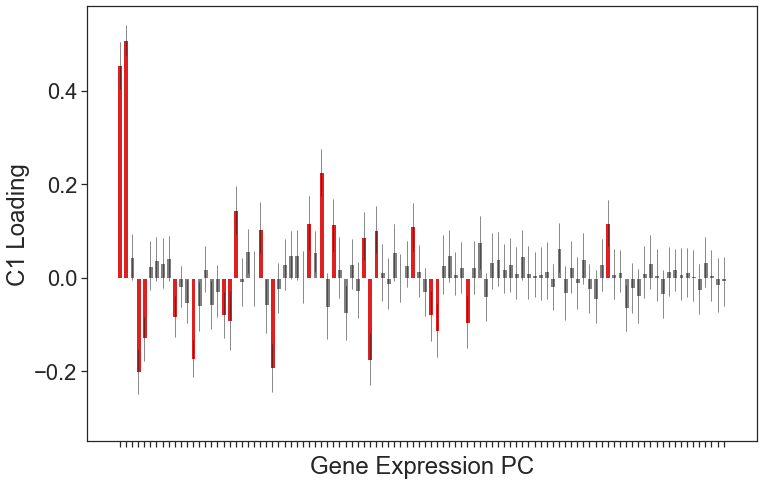

In [43]:
plotr = pandas.concat([pandas.Series(allx_bs[0].values.flatten()),
                       #pandas.Series(list(range(100))*500)],
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']
sns.set(font_scale=2)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]]
plt.subplots(figsize=(12,8))
g=sns.barplot(x='Component', y='Loading', data=plotr, palette=colors,
             ci=None)
for i in plotr.Component.unique():
    dist = sorted(plotr[plotr.Component==i].Loading.values)
    cil,ciu = dist[50],dist[-50]
    plt.plot([i,i],[cil,ciu],c='k',lw=.5)
plt.xlabel('Gene Expression PC')
plt.ylabel('C1 Loading')
plt.ylim(-.35,.58)
g.set_xticklabels([None for x in range(100)])
plt.savefig(os.path.join(fig_dir,'C1_XWeights.pdf'),bbox_inches='tight')

In [32]:
# plotr = pandas.concat([pandas.Series(allx_bs[0].values.flatten()),
#                        #pandas.Series(list(range(100))*500)],
#                        pandas.Series(list(range(100))*1000)],
#                       axis=1)
# plotr.columns = ['Loading','Component']
# sns.set(font_scale=1.5)
# sns.set_style('ticks')
# colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]]
# g=sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
# plt.xlabel('Gene Expression PC')
# plt.ylabel('C1 Loading')
# g.set_xticklabels([None for x in range(100)])
# plt.savefig(os.path.join(fig_dir,'C1_XWeights.pdf'),bbox_inches='tight')

In [10]:
sigs = multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,0] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]

In [11]:
newc1 = np.dot(pcamod.components_.T, new_loading)
newc1 = pandas.concat([pandas.Series(newc1), pandas.Series(bigdf.columns)],
                      axis=1)
newc1.columns = [0,'gene_symbol']

In [12]:
probe_index = pandas.DataFrame(probes,copy=True)
probe_index.index = probe_index.gene_symbol.values
for i,row in newc1.iterrows():
    if row['gene_symbol'] in probe_index.index:
        nm = probe_index.loc[row['gene_symbol'],'gene_name']
        if type(nm) == pandas.core.series.Series:
            newc1.loc[i,'gene_name'] = nm.values[0]
        elif pandas.notnull(nm):
            newc1.loc[i,'gene_name'] = nm

In [13]:
newc1.sort_values(0,ascending=False)

,0,gene_symbol,gene_name
12899,0.035606,STON1,stonin 1
10410,0.034528,PRPH,peripherin
12808,0.032047,ST3GAL6,"ST3 beta-galactoside alpha-2,3-sialyltransfera..."
7492,0.031447,LXN,latexin
1865,0.030245,CAVIN3,NaN
...,...,...,...
8095,-0.031483,MOXD1,"monooxygenase, DBH-like 1"
14783,-0.032096,WNT10A,"wingless-type MMTV integration site family, me..."
3025,-0.033480,CTXN3,cortexin 3
13807,-0.033964,TNNT2,troponin T type 2 (cardiac)


In [14]:
allcomps = pandas.DataFrame(newc1,copy=True)
allcomps.columns = ['C1','gene_symbol','gene_name']

In [15]:
c1_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc1[0])

In [16]:
gdf.loc[:,'C1_Expression'] = c1_xp

#### Get C2 X Genes

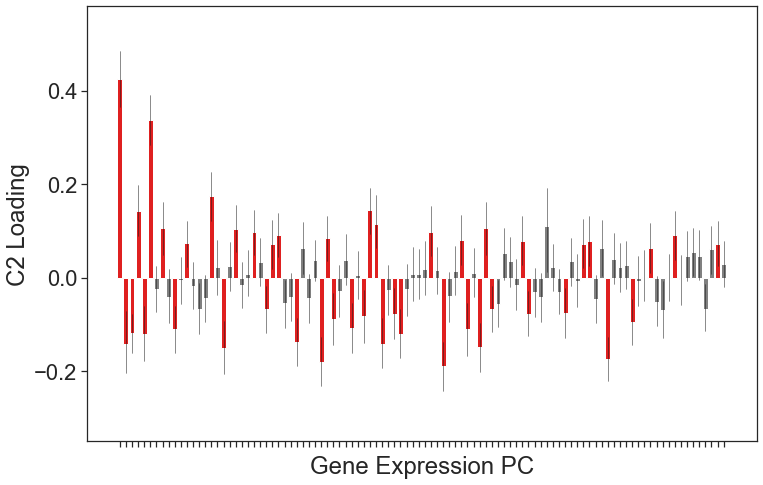

In [42]:
plotr = pandas.concat([pandas.Series(allx_bs[1].values.flatten()),
                       #pandas.Series(list(range(100))*500)],
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']
sns.set(font_scale=2)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[1], method='fdr_bh')[0]]
plt.subplots(figsize=(12,8))
g=sns.barplot(x='Component', y='Loading', data=plotr, palette=colors,
             ci=None)
for i in plotr.Component.unique():
    dist = sorted(plotr[plotr.Component==i].Loading.values)
    cil,ciu = dist[50],dist[-50]
    plt.plot([i,i],[cil,ciu],c='k',lw=.5)
plt.xlabel('Gene Expression PC')
plt.ylabel('C2 Loading')
plt.ylim(-.35,.58)
g.set_xticklabels([None for x in range(100)])
plt.savefig(os.path.join(fig_dir,'C2_XWeights.pdf'),bbox_inches='tight')

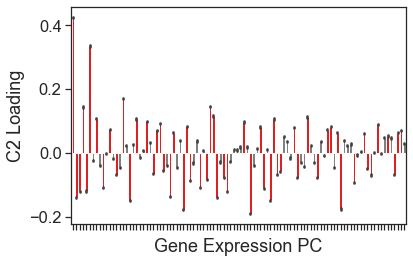

In [188]:
# plotr = pandas.concat([pandas.Series(allx_bs[1].values.flatten()),
#                        pandas.Series(list(range(100))*1000)],
#                       axis=1)
# plotr.columns = ['Loading','Component']
# colors = ['Red' if x < 0.05 else 'Grey' for x in bsrx['p'].loc[1]]
# g = sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
# plt.xlabel('Gene Expression PC')
# plt.ylabel('C2 Loading')
# g.set_xticklabels([None for x in range(100)])
# plt.savefig(os.path.join(fig_dir,'C2_XWeights.pdf'),bbox_inches='tight')

In [17]:
sigs = multipletests(bsrx['p'].loc[1], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,1] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
newc2 = np.dot(pcamod.components_.T, new_loading)
newc2 = pandas.concat([pandas.Series(newc2), pandas.Series(bigdf.columns)],
                      axis=1)
newc2.columns = [0,'gene_symbol']
for i,row in newc2.iterrows():
    if row['gene_symbol'] in probe_index.index:
        nm = probe_index.loc[row['gene_symbol'],'gene_name']
        if type(nm) == pandas.core.series.Series:
            newc2.loc[i,'gene_name'] = nm.values[0]
        elif pandas.notnull(nm):
            newc2.loc[i,'gene_name'] = nm

In [18]:
newc2.sort_values(0)

,0,gene_symbol,gene_name
7856,-0.044774,MET,met proto-oncogene (hepatocyte growth factor r...
13280,-0.043872,TDRD1,tudor domain containing 1
7936,-0.036955,MGP,matrix Gla protein
2716,-0.036528,COL5A1,"collagen, type V, alpha 1"
2820,-0.036081,CPLX2,complexin 2
...,...,...,...
13323,0.036712,TEX26,testis expressed 26
14227,0.038770,TUNAR,NaN
5500,0.038883,HCN4,hyperpolarization activated cyclic nucleotide-...
13355,0.039249,TGFBI,"transforming growth factor, beta-induced, 68kDa"


In [19]:
allcomps.loc[:,'C2'] = newc2[newc2.columns[0]].values

In [20]:
c2_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc2[0])

In [21]:
gdf.loc[:,'C2_Expression'] = c2_xp

#### Get C3 X Genes

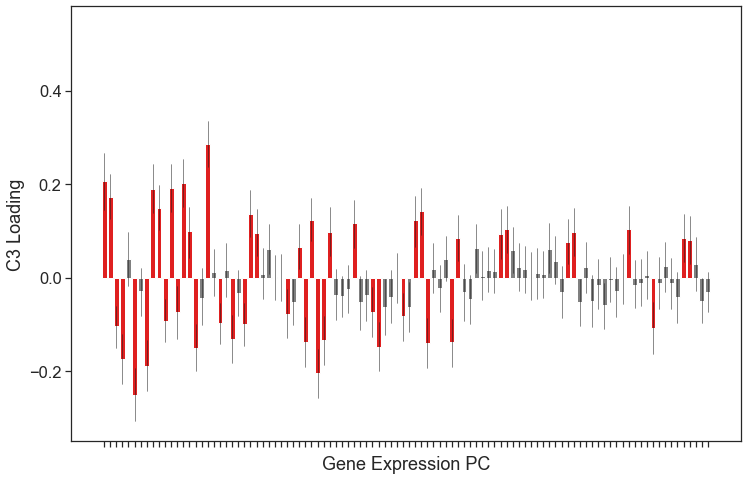

In [44]:
plotr = pandas.concat([pandas.Series(allx_bs[2].values.flatten()),
                       #pandas.Series(list(range(100))*500)],
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']
sns.set(font_scale=1.5)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[2], method='fdr_bh')[0]]
plt.subplots(figsize=(12,8))
g=sns.barplot(x='Component', y='Loading', data=plotr, palette=colors,
             ci=None)
for i in plotr.Component.unique():
    dist = sorted(plotr[plotr.Component==i].Loading.values)
    cil,ciu = dist[50],dist[-50]
    plt.plot([i,i],[cil,ciu],c='k',lw=.5)
plt.xlabel('Gene Expression PC')
plt.ylabel('C3 Loading')
plt.ylim(-.35,.58)
g.set_xticklabels([None for x in range(100)])
plt.savefig(os.path.join(fig_dir,'C3_XWeights.pdf'),bbox_inches='tight')

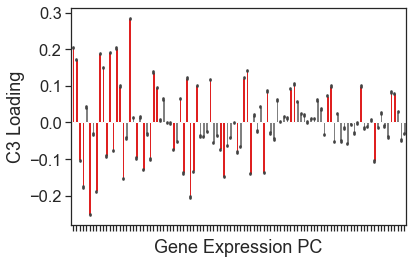

In [190]:
# plotr = pandas.concat([pandas.Series(allx_bs[2].values.flatten()),
#                        pandas.Series(list(range(100))*1000)],
#                       axis=1)
# plotr.columns = ['Loading','Component']
# sns.set(font_scale=1.5)
# sns.set_style('ticks')
# colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[2], method='fdr_bh')[0]]
# g = sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
# plt.xlabel('Gene Expression PC')
# plt.ylabel('C3 Loading')
# g.set_xticklabels([None for x in range(100)])
# plt.savefig(os.path.join(fig_dir,'C3_XWeights.pdf'),bbox_inches='tight')

In [22]:
sigs = multipletests(bsrx['p'].loc[2], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,2] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
newc3 = np.dot(pcamod.components_.T, new_loading)
newc3 = pandas.concat([pandas.Series(newc3), pandas.Series(bigdf.columns)],
                      axis=1)
newc3.columns = [0,'gene_symbol']
for i,row in newc3.iterrows():
    if row['gene_symbol'] in probe_index.index:
        nm = probe_index.loc[row['gene_symbol'],'gene_name']
        if type(nm) == pandas.core.series.Series:
            newc3.loc[i,'gene_name'] = nm.values[0]
        elif pandas.notnull(nm):
            newc3.loc[i,'gene_name'] = nm

In [23]:
newc3.sort_values(0,ascending=False)

,0,gene_symbol,gene_name
14647,0.040890,VSTM1,V-set and transmembrane domain containing 1
4803,0.039611,G0S2,G0/G1switch 2
11116,0.035995,RILP,Rab interacting lysosomal protein
7005,0.034377,LINC01158,NaN
13323,0.034335,TEX26,testis expressed 26
...,...,...,...
10553,-0.035171,PTGER4,prostaglandin E receptor 4 (subtype EP4)
12067,-0.035171,SLC22A10,"solute carrier family 22, member 10"
11576,-0.035349,SAPCD2,NaN
10043,-0.037966,PNMT,phenylethanolamine N-methyltransferase


In [24]:
allcomps.loc[:,'C3_Expression'] = newc3[newc3.columns[0]].values

In [25]:
c3_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc3[0])

In [26]:
gdf.loc[:,'C3_Expression'] = c3_xp

In [186]:
#allcomps.to_csv('/Users/jacobv/Science/PLS_GXP/all_comps.csv')

### Great component image to render on brain (NB#)

This next line requires you to have fsl installed, or have an MNI template laying around.

If you have fsl, you can find an MNI template inside its data directory. See `mni_pth` in code block below for example

In [27]:
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(hap.convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
for i,xpimg in enumerate([c1_xp,c2_xp,c3_xp]):
    print('working on C%s'%(i+1))
    nm = 'NEUR608_IMG_c%s'%(i+1)
    mni_pth = '/usr/local/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
    wdir = '/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/'
    gcx_img = hap.make_expression_image(xpimg, input_coords, mni_pth, 
                                        wdir, nm, 5, return_img=False)

In [28]:
ls /Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/NEUR608_IMG_c1_xp_image.nii.gz

BSComp_ABA_C1.pdf                      Lifespan_Component_Expression.pdf
BrSp_CompR_C1.pdf                      Lifespan_Component_Expression.png
BrSp_CompR_C2.pdf                      Lifespan_R.pdf
BrSp_CompR_C3.pdf                      Lifespan_R_decade.pdf
BrSp_CompR_labels.pdf                  Loadings_clusters.pdf
BrSp_CompR_overlay.pdf                 NEUR608_IMG_c1_xp_image.nii.gz
C1_BrainSpatialWB.pdf                  NEUR608_IMG_c2_xp_image.nii.gz
C1_Modals.pdf                          NEUR608_IMG_c3_xp_image.nii.gz
C1_NT.pdf                              NT_brain.html
C1_Tele.pdf                            NT_brain_test.html
C1_XWeights.nii.gz                     PCorr_NT_brain_predicted.html
C1_XWeights.pdf                        PheWAS_NDD.pdf
C2_BrainGxp.pdf                        PheWAS_brain.pdf
C2_BrainSpatialWB.pdf                  PheWAS_breakdown.ai
C2_Modals.pdf                          PheWAS_breakdown.png
C2_NT-NoTele.pdf                       PheWAS_full.pdf
C2_N

### Prepare for GSEA
i'm not currently doing GSEA but leaving this code in there just in case (though I haven't re-checked to see if it works....

In [62]:
rank = pandas.DataFrame(index = probes.gene_symbol.unique(), columns = ['beta'])
for i,gene in enumerate(probes.gene_symbol.unique()):
    for col in probes.columns[-3:]:
        db = probes[probes.gene_symbol==gene][col]
        if type(db) == float:
            rank.loc[gene,col] = db
        else:
            #rank.loc[gene,'beta'] = db.mean() # take mean
            rank.loc[gene,col] = db.iloc[np.argmax(db.values)] # take highest rank
    if i%1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


In [65]:
rank.drop('beta',axis=1,inplace=True)

In [70]:
rank.sort_values('C2',ascending=False).head()

,C1,C2,C3
MET,0.028332,0.065229,-0.033451
TTR,0.001506,0.040164,0.062039
SOST,-0.001465,0.037713,0.012148
DMRT3,0.000724,0.035849,0.011679
CYP26B1,0.010748,0.035243,-0.009855


In [73]:
new_rank = pandas.DataFrame(index = range(len(rank)))
new_rank.loc[:,'Symbol'] = rank.index
for col in rank.columns:
    new_rank.loc[:,col] = rank[col].values

new_rank.head()

,Symbol,C1,C2,C3
0,C8G,0.000702,0.000065,-0.005231
1,C9,0.000390,0.000572,0.001446
2,MRPL49,0.001989,0.000026,-0.003131
3,ZNHIT2,0.003456,-0.000876,0.000026
4,MPPED2,0.002161,-0.000839,-0.001553


In [ ]:
for col in rank.columns:
    new_rank.sort_values(col,ascending=False
                    )[['Symbol',col]].to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/LR_forGSEA_%s.rnk'%col,
                            sep = '\t', index=False)

# Save data for other notebooks

In [161]:
for i in range(1,4):
    c_vals = pandas.pivot_table(gdf,values='C%s_Expression'%i,
                                 index='brain_divison',aggfunc=np.mean
                                )
    for div in c_vals.index:
        sem = gdf[gdf.brain_divison==div]['C%s_Expression'%i
                                         ].sem()
        c_vals.loc[div,'sem'] = sem
    c_vals.to_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%i)
    c_vals.head()

In [81]:
# c2_vals = pandas.pivot_table(gdf,values='C2_Expression',
#                              index='brain_divison',aggfunc=np.mean
#                             )
# for div in c2_vals.index:
#     sem = gdf[gdf.brain_divison==div]['Component2_Expresion'].sem()
#     c2_vals.loc[div,'sem'] = sem
# #c2_vals.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/GCorr_BSComp_ABA_C2_data.csv')
# c2_vals.head()

,Component2_Expresion,sem
brain_divison,,
Alar_Medulla,0.240864,0.004213
Anterior_Cingulate,0.029204,0.012916
Basal_Medulla,0.268872,0.005458
Cerebellum,-0.245697,0.002831
DCN,0.214673,0.009641


In [164]:
### same thing for GTeX
for i in range(1,4):
    c_vals = pandas.pivot_table(gdf,values='C%s_Expression'%i,
                                 index='GTeX_div',aggfunc=np.mean
                                )
    for div in c_vals.index:
        sem = gdf[gdf.GTeX_div==div]['C%s_Expression'%i
                                         ].sem()
        c_vals.loc[div,'sem'] = sem
    c_vals.to_csv('data/GCorr_GTexComp_ABA_C%s_data.csv'%i)


# Projection

In [70]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf))
pls_mod = PLSRegression(n_components=3)
#full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

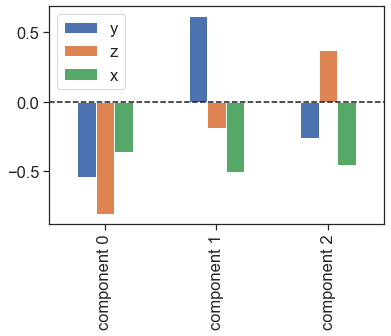

In [71]:
sns.set_context('notebook',font_scale=1.5)
pandas.DataFrame(pls_mod.y_weights_, 
                 index=['y','z','x'],
                 columns=['component %s'%x for x in range(3)]).T.plot.bar()
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'y_weights.pdf'),bbox_inches='tight')

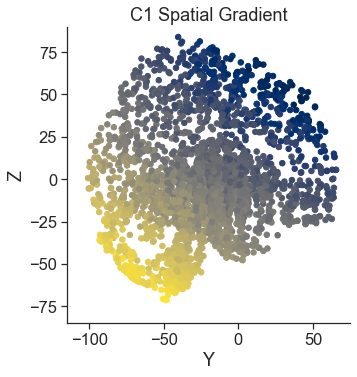

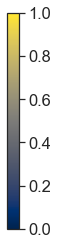

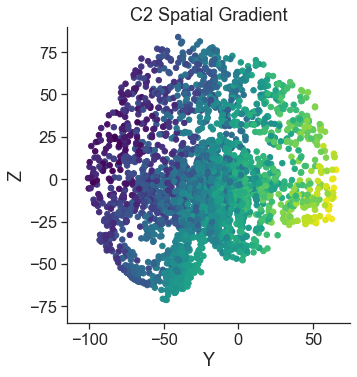

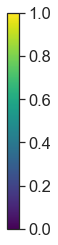

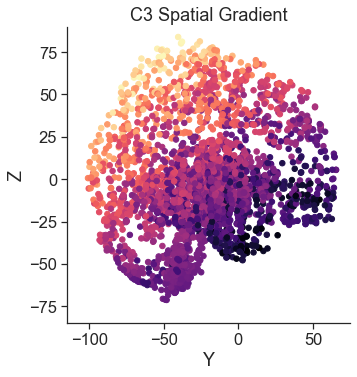

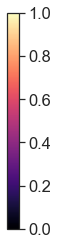

In [78]:
pals = ['cividis','viridis','magma']

for i in range(pls_mod.y_weights_.shape[0]):
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = np.dot(full_y.values,pls_mod.y_weights_[:,i])
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    gdf.loc[:,'C%s_SmoothGradient'%(i+1)] = sg
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='magma')
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Spatial Gradient'%(i+1))
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    plt.savefig(os.path.join(fig_dir,'brain_plot_SpatialC%s_YZ.png'%(i+1)),
                bbox_inches='tight')

    #if i == 0:
    # colorbar
    a = np.array([[0,1]])
    plt.figure(figsize=(.2, 5))
    img = plt.imshow(a, cmap=pals[i])
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    cbar = plt.colorbar(orientation="vertical", cax=cax)
    newticks = [round(norm.inverse(x),1) for x in cbar.get_ticks()]
    cbar.set_ticks(cbar.get_ticks())
    cbar.set_ticklabels(newticks)
    plt.savefig(os.path.join(fig_dir,'brain_plot_component%s_cbar.png'%(i+1)),
                                 bbox_inches='tight')

    plt.show()




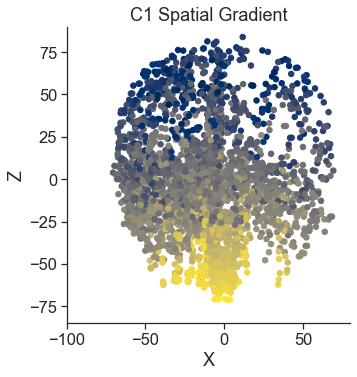

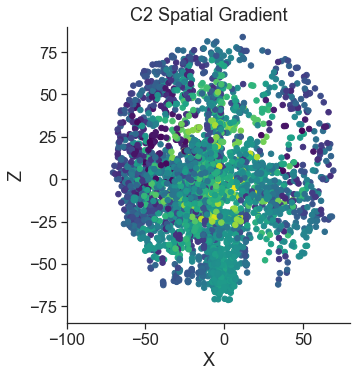

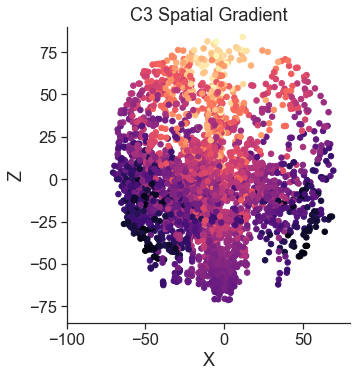

In [91]:
for i in range(pls_mod.y_weights_.shape[0]):
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = np.dot(full_y.values,pls_mod.y_weights_[:,i])
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    gdf.loc[:,'C%s_SmoothGradient'%(i+1)] = sg
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='viridis')
    
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.title('C%s Spatial Gradient'%(i+1))
    plt.ylim(-85,90)
    plt.xlim(-80,80)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    plt.savefig(os.path.join(fig_dir,'brain_plot_SpatialC%s_XZ.png'%(i+1)),
                bbox_inches='tight')



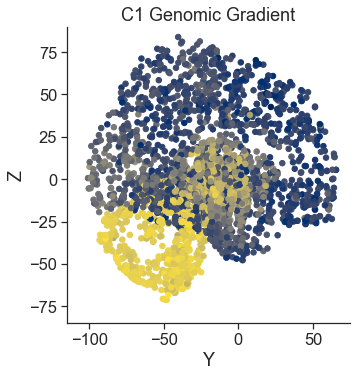

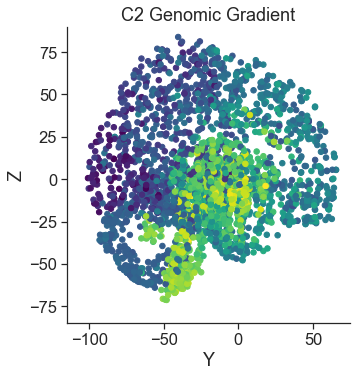

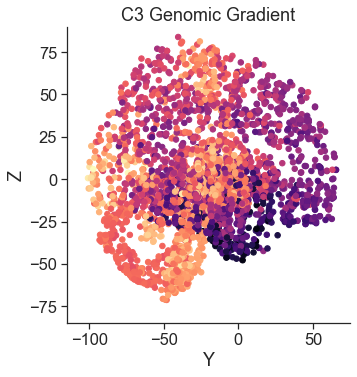

In [179]:
sns.set_context('notebook',font_scale=1.5)
for i in range(pls_mod.y_weights_.shape[0]):
    #if i == 2:
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = gdf.loc[:,'C%s_Expression'%(i+1)].values
    #else:
    #    sg = -gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  )
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Genomic Gradient'%(i+1))
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    plt.savefig(os.path.join(fig_dir,'brain_plot_GenomicC%s_YZ.png'%(i+1)),bbox_inches='tight')



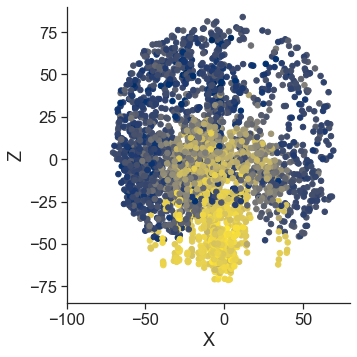

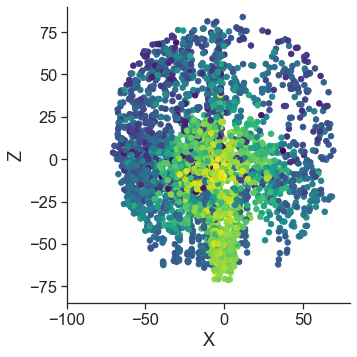

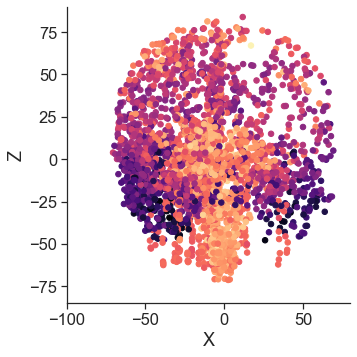

In [180]:
for i in range(pls_mod.y_weights_.shape[0]):
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = gdf.loc[:,'C%s_Expression'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z',  
                   data=gdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.ylim(-85,90)
    plt.xlim(-80,80)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
    plt.savefig(os.path.join(fig_dir,'brain_plot_GenomicC%s_XZ.png'%(i+1)),bbox_inches='tight')



# Gradient overlay

In [108]:
for i in range(pls_mod.y_weights_.shape[0]):
    sg = gdf.loc[:,'C%s_SmoothGradient'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    cut = pandas.cut(scaled_sg,10)
    code = dict(zip(np.unique(cut),range(1,len(np.unique(cut))+1)))
    gdf.loc[:,'C%s_SpatialGradient'%(i+1)] = [code[x] for x in cut]

code = dict(zip(range(1,11), [1,1,1,2,2,2,2,3,3,3]))
conversion = []
for i,row in gdf.iterrows():
    conversion.append('%s%s%s'%(code[row['C1_SpatialGradient']],
                          code[row['C2_SpatialGradient']],
                          code[row['C3_SpatialGradient']]))
code = dict(zip(np.unique(conversion),
               range(1,len(np.unique(conversion))+1)))
gdf.loc[:,'GradExp_Gp'] = [code[x] for x in conversion]

In [107]:
code

{'111': 1,
 '112': 2,
 '113': 3,
 '121': 4,
 '122': 5,
 '123': 6,
 '131': 7,
 '132': 8,
 '211': 9,
 '212': 10,
 '213': 11,
 '221': 12,
 '222': 13,
 '223': 14,
 '231': 15,
 '232': 16,
 '311': 17,
 '312': 18,
 '313': 19,
 '321': 20,
 '322': 21}

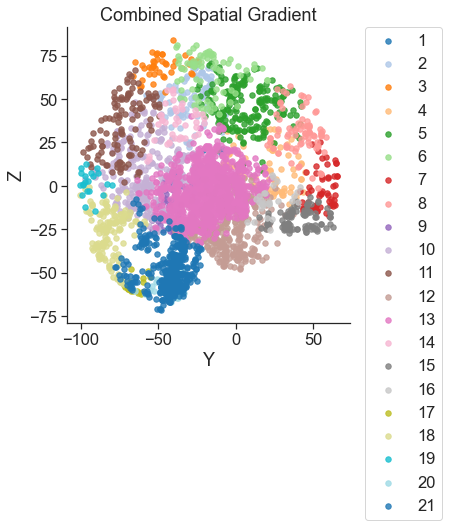

In [110]:
sns.set_context('notebook',font_scale=1.5)
sns.lmplot(x='mni_nlin_y', y='mni_nlin_z', 
               hue = 'GradExp_Gp',legend=False, 
               data=gdf, fit_reg=False, 
               scatter_kws={"s": 30},
              palette='tab20')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Combined Spatial Gradient')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

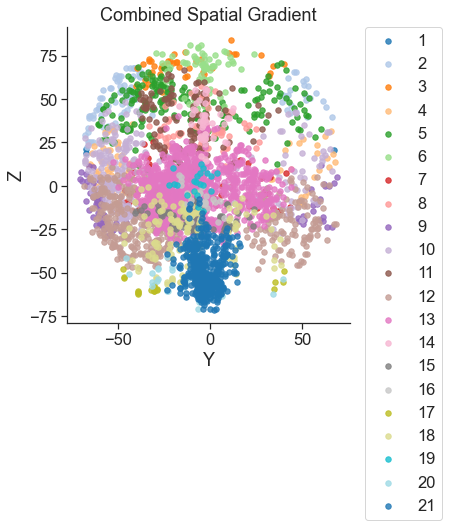

In [118]:
sns.lmplot(x='mni_nlin_x', y='mni_nlin_z', 
               hue = 'GradExp_Gp',legend=False, 
               data=gdf, fit_reg=False, 
               scatter_kws={"s": 30},
              palette='tab20')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Combined Spatial Gradient')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [112]:
for i in range(pls_mod.y_weights_.shape[0]):
    sg = gdf.loc[:,'C%s_Expression'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    cut = pandas.cut(scaled_sg,10)
    code = dict(zip(np.unique(cut),range(1,len(np.unique(cut))+1)))
    gdf.loc[:,'C%s_TxGradient'%(i+1)] = [code[x] for x in cut]

code = dict(zip(range(1,11), [1,1,1,2,2,2,2,3,3,3]))
conversion = []
for i,row in gdf.iterrows():
    conversion.append('%s%s%s'%(code[row['C1_TxGradient']],
                          code[row['C2_TxGradient']],
                          code[row['C3_TxGradient']]))
code = dict(zip(np.unique(conversion),
               range(1,len(np.unique(conversion))+1)))
gdf.loc[:,'GeneGradExp_Gp'] = [code[x] for x in conversion]

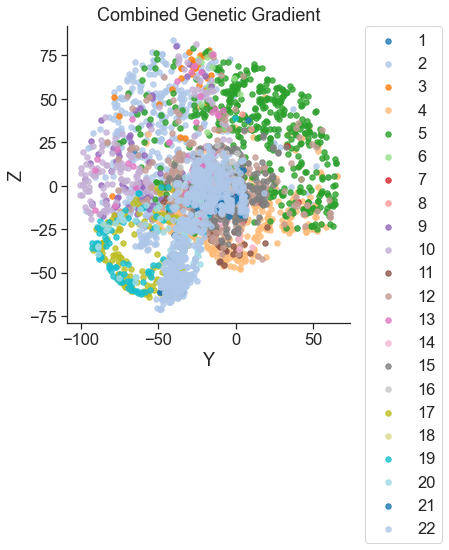

In [113]:
sns.set_context('notebook',font_scale=1.5)
sns.lmplot(x='mni_nlin_y', y='mni_nlin_z', 
               hue = 'GeneGradExp_Gp',legend=False, 
               data=gdf, fit_reg=False, 
               scatter_kws={"s": 30},
              palette='tab20')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Combined Genetic Gradient')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

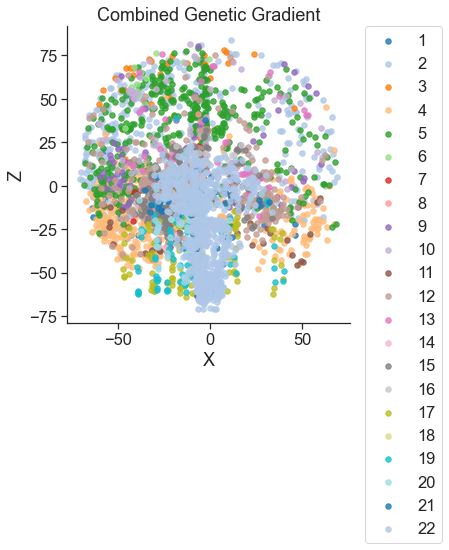

In [117]:
sns.set_context('notebook',font_scale=1.5)
sns.lmplot(x='mni_nlin_x', y='mni_nlin_z', 
               hue = 'GeneGradExp_Gp',legend=False, 
               data=gdf, fit_reg=False, 
               scatter_kws={"s": 30},
              palette='tab20')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Combined Genetic Gradient')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Understanding the components

In [43]:
Medulla = ['arcuate nucleus of medulla, left','arcuate nucleus of medulla, right',
                 'central glial substance',
                 'central medullary reticular group, left','central medullary reticular group, right',
                 'cochlear nuclei, left','cochlear nuclei, right',
                 'cuneate nucleus, left','cuneate nucleus, right',
                 'dorsal motor nucleus of the vagus, left','dorsal motor nucleus of the vagus, right',
                 'gigantocellular group, left','gigantocellular group, right',
                 'gracile nucleus, left','gracile nucleus, right',
                 'hypoglossal nucleus, left','hypoglossal nucleus, right',
                 'inferior olivary complex, left','inferior olivary complex, right',
                 'lateral medullary reticular group, left','lateral medullary reticular group, right',
                 'raphe nuclei of medulla',
                 'spinal trigeminal nucleus, left','spinal trigeminal nucleus, right',
                 'superior olivary complex, left','superior olivary complex, right',
                 'vestibular nuclei, left','vestibular nuclei, right']

Pons =          ['abducens nucleus, left','abducens nucleus, right',
                 'central gray of the pons, left','central gray of the pons, right',
                 'facial motor nucleus, left','facial motor nucleus, right',
                 'lateral parabrachial nucleus, left','lateral parabrachial nucleus, right',
                 'locus ceruleus, left','locus ceruleus, right',
                 'medial parabrachial nucleus, left','medial parabrachial nucleus, right',
                 'medial parabrachial nucleus,right',
                 'motor nucleus of trigeminal nerve, left','motor nucleus of trigeminal nerve, right',
                 'nucleus subceruleus, left','nucleus subceruleus, right',
                 'pontine nuclei, left','pontine nuclei, right',
                 'pontine raphe nucleus','pontine raphe nucleus, left',
                 'pontine reticular formation, left','pontine reticular formation, right',
                 'principal sensory nucleus of trigeminal nerve, left','principal sensory nucleus of trigeminal nerve, right',
                 ]

DCN = ['dentate nucleus, left',
       'dentate nucleus, right',
       'emboliform nucleus, left',
       'emboliform nucleus, right',
       'fastigial nucleus, left',
       'fastigial nucleus, right',
       'globose nucleus, left',
       'globose nucleus, right']

Cerebellum = [x for x in gdf[gdf.slab_type=='CB']['structure_name'].unique().tolist() if x not in DCN]

Tectum = ['inferior colliculus, left',
          'superior colliculus, left','superior colliculus, right',
          'pretectal region']

Tegmentum = ['central gray substance of midbrain, left','central gray substance of midbrain, right',
            'cuneiform nucleus, left','cuneiform nucleus, right',
            'Edinger-Westphal nucleus, left','Edinger-Westphal nucleus, right',
            'interstitial nucleus of Cajal, left','interstitial nucleus of Cajal, right',
            'midbrain raphe nuclei','midbrain raphe nuclei, left',
            'midbrain reticular formation, left','midbrain reticular formation, right',
            'nucleus of Darkschewitsch, left',
            'oculomotor nuclear complex, right','oculomotor nuclear complex, left',
            'red nucleus, left','red nucleus, right',
            'subcuneiform nucleus, left','subcuneiform nucleus, right',
            'substantia nigra, pars compacta, left','substantia nigra, pars compacta, right',
            'substantia nigra, pars reticulata, left','substantia nigra, pars reticulata, right',
            'trochlear nucleus, left','trochlear nucleus, right',
            'ventral tegmental area, left','ventral tegmental area, right']

Hypothalamus = ['anterior hypothalamic area, left','anterior hypothalamic area, right',
               'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
               'dorsomedial hypothalamic nucleus, left',
               'lateral hypothalamic area, anterior region, left', 'lateral hypothalamic area, anterior region, right',
               'lateral hypothalamic area, mammillary region, left', 'lateral hypothalamic area, mammillary region, right',
               'lateral hypothalamic area, tuberal region, left',
               'paraventricular nucleus of the hypothalamus, left','paraventricular nucleus of the hypothalamus, right',
               'perifornical nucleus, left',
               'posterior hypothalamic area, left','posterior hypothalamic area, right',
               'preoptic region, left','preoptic region, right',
               'supraoptic nucleus, left','supraoptic nucleus, right',
               'ventromedial hypothalamic nucleus, left','ventromedial hypothalamic nucleus, right',]
                

Thalamus = ['anterior group of nuclei, left','anterior group of nuclei, right',
           'caudal group of intralaminar nuclei, left','caudal group of intralaminar nuclei, right',
           'dorsal lateral geniculate nucleus, left','dorsal lateral geniculate nucleus, right',
           'lateral group of nuclei, left, dorsal division','lateral group of nuclei, left, ventral division',
           'lateral group of nuclei, right, dorsal division','lateral group of nuclei, right, ventral division',
           'medial geniculate complex, left','medial geniculate complex, right',
           'medial group of nuclei, left','medial group of nuclei, right',
           'reticular nucleus of thalamus, left','reticular nucleus of thalamus, right',
           'rostral group of intralaminar nuclei, left','rostral group of intralaminar nuclei, right',
           'paraventricular nuclei, left of thalamus, left','paraventricular nuclei, right of thalamus, right',
           'posterior group of nuclei, left','posterior group of nuclei, right',
           'subthalamic nucleus, left','subthalamic nucleus, right',
           'zona incerta, left','zona incerta, right']

Other_Dien = ['lateral habenular nucleus, left','lateral habenular nucleus, right',
             'lateral mammillary nucleus, left',
             'lateral tuberal nucleus, left',
             'mammillary body, left','mammillary body, right',
             'medial habenular nucleus, left','medial habenular nucleus, right',
             'medial mammillary nucleus, left',
             'pallidohypothalamic nucleus, left',
             'pineal gland',
             'supramammillary nucleus, left',
             'tuberomammillary nucleus, left']

Limbic = ['CA1 field, left','CA1 field, right',
          'CA2 field, left','CA2 field, right',
          'CA3 field, left','CA3 field, right',
          'CA4 field, left','CA4 field, right',
          'amygdalohippocampal transition zone, left',
          'amygdalohippocampal transition zone, right',
          'basolateral nucleus, left','basolateral nucleus, right',
          'basomedial nucleus, left','basomedial nucleus, right',
          'central nucleus, left','central nucleus, right',
          'cortico-medial group, left','cortico-medial group, right',
          'dentate gyrus, left','dentate gyrus, right',
          'lateral nucleus, left','lateral nucleus, right',
          'septal nuclei, left','septal nuclei, right',
         'subiculum, left','subiculum, right']

Forebrain = ['basal nucleus of meynert, left','basal nucleus of meynert, right',
            'nucleus accumbens, left','nucleus accumbens, right',
            'nucleus of the diagonal band, left, horizontal division',
            'nucleus of the diagonal band, left, vertical division',
            'olfactory tubercle, left', 'piriform cortex, left',
            'substantia innominata, left','substantia innominata, right']

Striatum = ['bed  nucleus of stria terminalis, left',
            'body of caudate nucleus, left',
            'body of caudate nucleus, right',
            'globus pallidus, external segment, left','globus pallidus, external segment, right',
            'globus pallidus, internal segment, left','globus pallidus, internal segment, right',
            'head of caudate nucleus, left','head of caudate nucleus, right',
            'olfactory tubercle, left',
            'putamen, left','putamen, right',
           'tail of caudate nucleus, left','tail of caudate nucleus, right']

Anterior_Cingulate = ['cingulate gyrus, frontal part, left, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, left, superior bank of gyrus',
                     'cingulate gyrus, frontal part, right, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, right, superior bank of gyrus',
                     'paraterminal gyrus, right',
                     'parolfactory gyri, left','parolfactory gyri, right',
                     'subcallosal cingulate gyrus, left','subcallosal cingulate gyrus, right']

Posterior_Cingulate = ['cingulate gyrus, parietal part, left, inferior bank of gyrus',
                     'cingulate gyrus, parietal part, left, superior bank of gyrus',
                     'cingulate gyrus, parietal part, right, inferior bank of gyrus',
                     'cingulate gyrus, parietal part, right, superior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, left, inferior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, left, superior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, right, inferior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, right, superior bank of gyrus',]

Insula = ['claustrum, left','claustrum, right',
         'long insular gyri, left','long insular gyri, right',
         'short insular gyri, left','short insular gyri, right',]

Temporal = ["Heschl's gyrus, left", "Heschl's gyrus, right",
           'fusiform gyrus, left, bank of cos','fusiform gyrus, left, bank of the its',
           'fusiform gyrus, left, lateral bank of gyrus','fusiform gyrus, right, bank of cos',
           'fusiform gyrus, right, bank of the its','fusiform gyrus, right, lateral bank of gyrus',
           'inferior temporal gyrus, left, bank of mts','inferior temporal gyrus, left, bank of the its',
           'inferior temporal gyrus, left, lateral bank of gyrus','inferior temporal gyrus, right, bank of mts',
           'inferior temporal gyrus, right, bank of the its','inferior temporal gyrus, right, lateral bank of gyrus',
           'middle temporal gyrus, left, inferior bank of gyrus','middle temporal gyrus, left, superior bank of gyrus',
           'middle temporal gyrus, right, inferior bank of gyrus','middle temporal gyrus, right, superior bank of gyrus',
           'occipito-temporal gyrus, left, inferior bank of gyrus','occipito-temporal gyrus, left, superior bank of gyrus',
           'occipito-temporal gyrus, right, inferior bank of gyrus','occipito-temporal gyrus, right, superior bank of gyrus',
           'parahippocampal gyrus, left, bank of the cos','parahippocampal gyrus, left, lateral bank of gyrus',
           'parahippocampal gyrus, right, bank of the cos','parahippocampal gyrus, right, lateral bank of gyrus',
           'superior temporal gyrus, left, inferior bank of gyrus','superior temporal gyrus, left, lateral bank of gyrus',
           'superior temporal gyrus, right, inferior bank of gyrus','superior temporal gyrus, right, lateral bank of gyrus',
           'temporal pole, left, inferior aspect','temporal pole, left, medial aspect',
           'temporal pole, left, superior aspect','temporal pole, right, inferior aspect',
           'temporal pole, right, medial aspect','temporal pole, right, superior aspect',
           'transverse gyri, left','transverse gyri, right',
           'planum polare, left','planum polare, right',
           'planum temporale, left','planum temporale, right']

Parietal = ['angular gyrus, left, inferior bank of gyrus','angular gyrus, left, superior bank of gyrus',
            'angular gyrus, right, inferior bank of gyrus','angular gyrus, right, superior bank of gyrus',
            'precuneus, left, inferior lateral bank of gyrus','precuneus, left, superior lateral bank of gyrus',
            'precuneus, right, inferior lateral bank of gyrus','precuneus, right, superior lateral bank of gyrus',
            'superior parietal lobule, left, inferior bank of gyrus','superior parietal lobule, left, superior bank of gyrus',
            'superior parietal lobule, right, inferior bank of gyrus','superior parietal lobule, right, superior bank of gyrus',
            'supramarginal gyrus, left, inferior bank of gyrus','supramarginal gyrus, left, superior bank of gyrus',
            'supramarginal gyrus, right, inferior bank of gyrus','supramarginal gyrus, right, superior bank of gyrus']

Frontal = ['anterior orbital gyrus, left','anterior orbital gyrus, right',
           'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
          'frontal operculum, left','frontal operculum, right',
          'frontal pole, left, inferior aspect','frontal pole, left, medial aspect',
          'frontal pole, left, superior aspect','frontal pole, right, inferior aspect',
          'frontal pole, right, medial aspect','frontal pole, right, superior aspect',
          'gyrus rectus, left','gyrus rectus, right',
          'inferior frontal gyrus, opercular part, left','inferior frontal gyrus, opercular part, right',
          'inferior frontal gyrus, orbital part, left','inferior frontal gyrus, orbital part, right',
          'inferior frontal gyrus, triangular part, left','inferior frontal gyrus, triangular part, right',
          'inferior rostral gyrus, left','inferior rostral gyrus, right',
          'lateral orbital gyrus, left','lateral orbital gyrus, right',
          'medial orbital gyrus, left','medial orbital gyrus, right',
          'middle frontal gyrus, left, inferior bank of gyrus','middle frontal gyrus, left, superior bank of gyrus',
          'middle frontal gyrus, right, inferior bank of gyrus','middle frontal gyrus, right, superior bank of gyrus',
          'posterior orbital gyrus, left','posterior orbital gyrus, right',
          'superior frontal gyrus, left','superior frontal gyrus, left, lateral bank of gyrus',
          'superior frontal gyrus, left, medial bank of gyrus','superior frontal gyrus, right, lateral bank of gyrus',
          'superior frontal gyrus, right, medial bank of gyrus',
          'superior rostral gyrus, left','superior rostral gyrus, right']

Occipital = ['cuneus, left, peristriate',
             'cuneus, left, striate',
             'cuneus, right, peristriate',
             'cuneus, right, striate',
             'inferior occipital gyrus, left, inferior bank of gyrus','inferior occipital gyrus, left, superior bank of gyrus',
             'inferior occipital gyrus, right, inferior bank of gyrus','inferior occipital gyrus, right, superior bank of gyrus',
             'lingual gyrus, left, peristriate','lingual gyrus, left, striate',
             'lingual gyrus, right, peristriate','lingual gyrus, right, striate',
             'occipital pole, left, inferior aspect',
             'occipital pole, left, lateral aspect','occipital pole, left, superior aspect',
             'superior occipital gyrus, left, inferior bank of gyrus','superior occipital gyrus, left, superior bank of gyrus',
             'superior occipital gyrus, right, inferior bank of gyrus','superior occipital gyrus, right, superior bank of gyrus',]

Sensorimotor = ['paracentral lobule, anterior part, left','paracentral lobule, anterior part, left, inferior bank of gyrus',
                'paracentral lobule, anterior part, left, superior bank of gyrus','paracentral lobule, anterior part, right, inferior bank of gyrus',
                'paracentral lobule, anterior part, right, superior bank of gyrus','paracentral lobule, posterior part, left, bank of cingulate sulcus',
                'paracentral lobule, posterior part, left, lateral bank of gyrus','paracentral lobule, posterior part, right, bank of cingulate sulcus',
                'paracentral lobule, posterior part, right, lateral bank of gyrus',
                'postcentral gyrus, left, bank of the central sulcus','postcentral gyrus, left, bank of the posterior central sulcus',
                'postcentral gyrus, left, inferior lateral aspect of gyrus','postcentral gyrus, left, superior lateral aspect of gyrus',
                'postcentral gyrus, right, bank of the central sulcus','postcentral gyrus, right, bank of the posterior central sulcus',
                'postcentral gyrus, right, inferior lateral aspect of gyrus','postcentral gyrus, right, superior lateral aspect of gyrus',
                'precentral gyrus, left, bank of the central sulcus','precentral gyrus, left, bank of the precentral sulcus',
                'precentral gyrus, left, inferior lateral aspect of gyrus','precentral gyrus, left, superior lateral aspect of gyrus',
                'precentral gyrus, right, bank of the central sulcus','precentral gyrus, right, bank of the precentral sulcus',
                'precentral gyrus, right, inferior lateral aspect of gyrus','precentral gyrus, right, superior lateral aspect of gyrus']
            
divs = [Medulla, Pons, DCN, Cerebellum, Tectum, Tegmentum, Hypothalamus, Thalamus, Other_Dien,
                  Limbic, Forebrain, Striatum, Anterior_Cingulate, Posterior_Cingulate, Insula,
                  Temporal, Frontal, Parietal, Occipital, Sensorimotor]
names = ['Medulla', 'Pons', 'DCN', 'Cerebellum', 'Tectum', 'Tegmentum', 'Hypothalamus', 'Thalamus', 
         'Other_Dien', 'Limbic', 'Forebrain', 'Striatum', 'Anterior_Cingulate', 'Posterior_Cingulate', 
         'Insula', 'Temporal', 'Frontal', 'Parietal', 'Occipital', 'Sensorimotor']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'brain_divison'] = name
    

In [44]:
# For C1
Meyelencephalon = Medulla[:] 
Metencelphalon = Pons + DCN + Cerebellum
Mesencephalon = Tectum + Tegmentum
Diencephalon = Hypothalamus + Thalamus + Other_Dien
Telencephalon = Limbic + Forebrain + Striatum + Anterior_Cingulate + Posterior_Cingulate +\
                Insula + Temporal + Frontal + Parietal + Occipital + Sensorimotor

divs = [Meyelencephalon, Metencelphalon, Mesencephalon, Diencephalon, Telencephalon]
names = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 'Diencephalon', 'Telencephalon']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'Neural_Tube_segment'] = name
    

In [45]:
# For C3

Auditory = ["Heschl's gyrus, left", "Heschl's gyrus, right",
            'planum polare, left','planum polare, right',
            'planum temporale, left','planum temporale, right',
            'transverse gyri, left','transverse gyri, right']
Visual = ['cuneus, left, peristriate','cuneus, left, striate',
                 'cuneus, right, peristriate','cuneus, right, striate',
                 'lingual gyrus, left, peristriate','lingual gyrus, left, striate',
                 'lingual gyrus, right, peristriate','lingual gyrus, right, striate']
Olfactory = ['olfactory tubercle, left', 'piriform cortex, left']


Sensory_Cortex = Sensorimotor + Auditory + Visual + Olfactory
gdf.loc[gdf[gdf.structure_name.isin(Sensory_Cortex)].index,'Cortical_Type'] = 'Sensory'

Association_Cortex = [x for x in Telencephalon if x not in Striatum and x not in Sensory_Cortex]
gdf.loc[gdf[gdf.structure_name.isin(Association_Cortex)].index,'Cortical_Type'] = 'Association_Cortex'

Cerebellar_Cortex = [x for x in Cerebellum]
gdf.loc[gdf[gdf.structure_name.isin(Cerebellar_Cortex)].index,'Cortical_Type'] = 'Cerebellar_Cortex'

Not_Cortex = Meyelencephalon + Mesencephalon + Pons + DCN + Diencephalon + Striatum
gdf.loc[gdf[gdf.structure_name.isin(Not_Cortex)].index,'Cortical_Type'] = 'Not Cortex'


divs = [Auditory, Visual, Olfactory, Sensorimotor, Association_Cortex, Not_Cortex, Cerebellar_Cortex]
names = ['Auditory','Visual','Olfactory','Sensorimotor','Association_Cortex','Not_Cortex','Cerebellar_Cortex']
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'Sensory_Type'] = name


In [46]:
# for c2
alar_medulla = ['spinal trigeminal nucleus, right', 'spinal trigeminal nucleus, left',
               'cochlear nuclei, left','cochlear nuclei, right',
               'vestibular nuclei, left','vestibular nuclei, right',
               'inferior olivary complex, left','inferior olivary complex, right',
                'gracile nucleus, left','gracile nucleus, right',
               'cuneate nucleus, left','cuneate nucleus, right',
               'superior olivary complex, left','superior olivary complex, right',]

basal_medulla = ['hypoglossal nucleus, left','hypoglossal nucleus, right',
                'lateral medullary reticular group, left','lateral medullary reticular group, right',
                'dorsal motor nucleus of the vagus, left','dorsal motor nucleus of the vagus, right', 
                'arcuate nucleus of medulla, left','arcuate nucleus of medulla, right',
                'central medullary reticular group, left','central medullary reticular group, right',
                'raphe nuclei of medulla',
                'gigantocellular group, left','gigantocellular group, right', ]


divs = [alar_medulla, basal_medulla]
names = ['Alar_Medulla','Basal_Medulla']
med_division = dict(zip(names,divs))

for name, div in med_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'brain_divison'] = name

dorsal_plate = ['Cerebellum', 'Thalamus', 'Tectum', 'Alar_Medulla']
ventral_plate = ['Hypothalamus','Pons','Tegmentum','Basal_Medulla']
subcortical = ['Forebrain', 'Striatum', 'Limbic']
frontal = ['Anterior_Cingulate','Insula','Frintal']
temporal = ['Temporal']
somatomotor = ['Sensorimotor']
parietal = ['Parietal']
occipital = ['Occipital']

gdf.loc[gdf[gdf.brain_divison.isin(dorsal_plate)].index,'Neural_Plate'] = 'Dorsal'
gdf.loc[gdf[gdf.brain_divison.isin(ventral_plate)].index,'Neural_Plate'] = 'Ventral'
gdf.loc[gdf[gdf.brain_divison.isin(subcortical)].index,'Neural_Plate'] = 'Subcortical'
gdf.loc[gdf[gdf.brain_divison.isin(frontal)].index,'Neural_Plate'] = 'Frontal'
gdf.loc[gdf[gdf.brain_divison.isin(temporal)].index,'Neural_Plate'] = 'Temporal'
gdf.loc[gdf[gdf.brain_divison.isin(somatomotor)].index,'Neural_Plate'] = 'Somatomotor'
gdf.loc[gdf[gdf.brain_divison.isin(parietal)].index,'Neural_Plate'] = 'Parietal'
gdf.loc[gdf[gdf.brain_divison.isin(occipital)].index,'Neural_Plate'] = 'Occipital'


In [47]:
# for GTeX

gfrontal = Frontal
gAC = Anterior_Cingulate
gCereb = Cerebellum
gHT = Hypothalamus
gCaud = ['body of caudate nucleus, left',
         'body of caudate nucleus, right',
        'head of caudate nucleus, left',
         'head of caudate nucleus, right',
        'tail of caudate nucleus, left',
         'tail of caudate nucleus, right']
gPut = ['putamen, left','putamen, right',]
gGP = ['globus pallidus, external segment, left',
       'globus pallidus, external segment, right',
       'globus pallidus, internal segment, left',
       'globus pallidus, internal segment, right',]
gAmyg = ['basolateral nucleus, left','basolateral nucleus, right',
          'basomedial nucleus, left','basomedial nucleus, right',
          'central nucleus, left','central nucleus, right',
          'cortico-medial group, left','cortico-medial group, right',
        'lateral nucleus, left','lateral nucleus, right']
gHipp = ['CA1 field, left','CA1 field, right',
          'CA2 field, left','CA2 field, right',
          'CA3 field, left','CA3 field, right',
          'CA4 field, left','CA4 field, right',
         'dentate gyrus, left','dentate gyrus, right',
        'subiculum, left','subiculum, right']
sn = ['substantia nigra, pars compacta, left',
      'substantia nigra, pars compacta, right',
      'substantia nigra, pars reticulata, left',
      'substantia nigra, pars reticulata, right']
gNAcc = ['nucleus accumbens, left','nucleus accumbens, right',]

divs = [gfrontal, gAC, gCereb, gHT, gCaud, gPut, gGP, gAmyg, 
        gHipp,sn,gNAcc]
names = ['Frontal', 'AntCing', 'Cerebellum', 'Hypothalamus', 
         'Caudate','Putamen','Pallidum','Amygdala','Hippocampus',
        'Nigra','Accumbens']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'GTeX_div'] = name
    

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 16.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


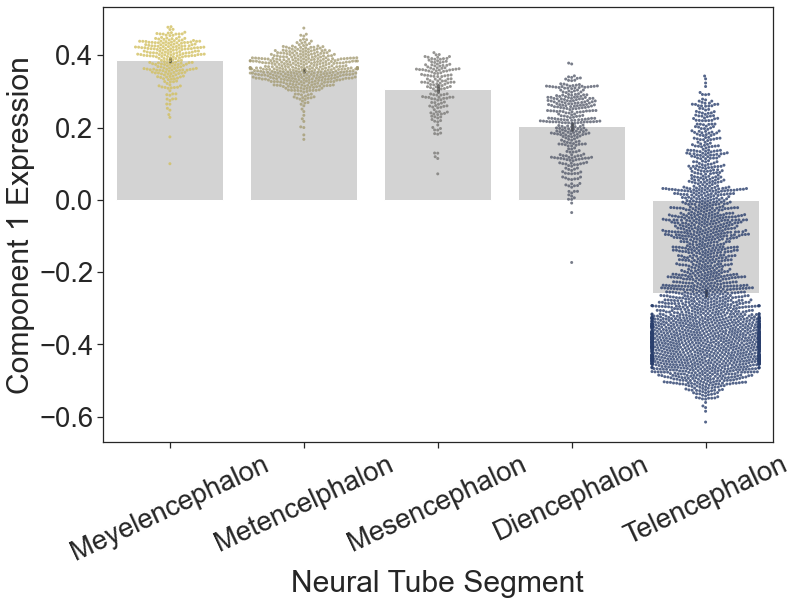

In [137]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 
         'Diencephalon', 'Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='C1_Expression', 
            data=gdf,color='lightgray',
           order = order)
g=sns.swarmplot(x='Neural_Tube_segment', y='C1_Expression', 
              data=gdf, size=3,alpha=0.8,
              order = order, palette='cividis_r')
g.set_xticklabels(order,rotation=25)
plt.xlabel('Neural Tube Segment')
plt.ylabel('Component 1 Expression')
plt.savefig(os.path.join(fig_dir,'C1_NT.png'),bbox_inches='tight')

In [143]:
rbpal = [sns.color_palette('cividis')[-1],
                      sns.color_palette('cividis')[0]]

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 18.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, '')

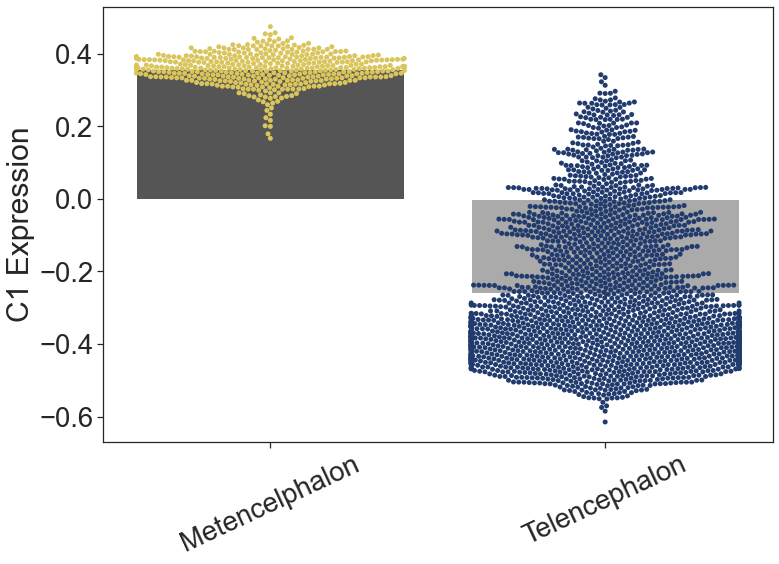

In [144]:
# Just cortex and cerebellum
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Metencelphalon','Telencephalon']
sns.barplot(x='Neural_Tube_segment', y='C1_Expression', 
            data=gdf[gdf.Neural_Tube_segment.isin(order)],
            palette='gray',
           order = order
           )
g=sns.swarmplot(x='Neural_Tube_segment', y='C1_Expression', 
              data=gdf[gdf.Neural_Tube_segment.isin(order)], 
              order = order, palette=rbpal)
g.set_xticklabels(order,rotation=25)
plt.ylabel('C1 Expression')
plt.xlabel('')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/BSComp_ABA_C1.pdf',
#            bbox_inches='tight')

In [145]:
bsn = []
for x in gdf.structure_name.values:
    if ',' in x:
        bsn.append(x.split(',')[0])
    else:
        bsn.append(x)
gdf.loc[:,'bilateral_structure_name'] = bsn

In [146]:
gdf.Sensory_Type.value_counts()

Association_Cortex    1725
Not_Cortex            1098
Cerebellar_Cortex      256
Sensorimotor           215
Visual                 107
Auditory                60
Olfactory                3
Name: Sensory_Type, dtype: int64

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 7.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


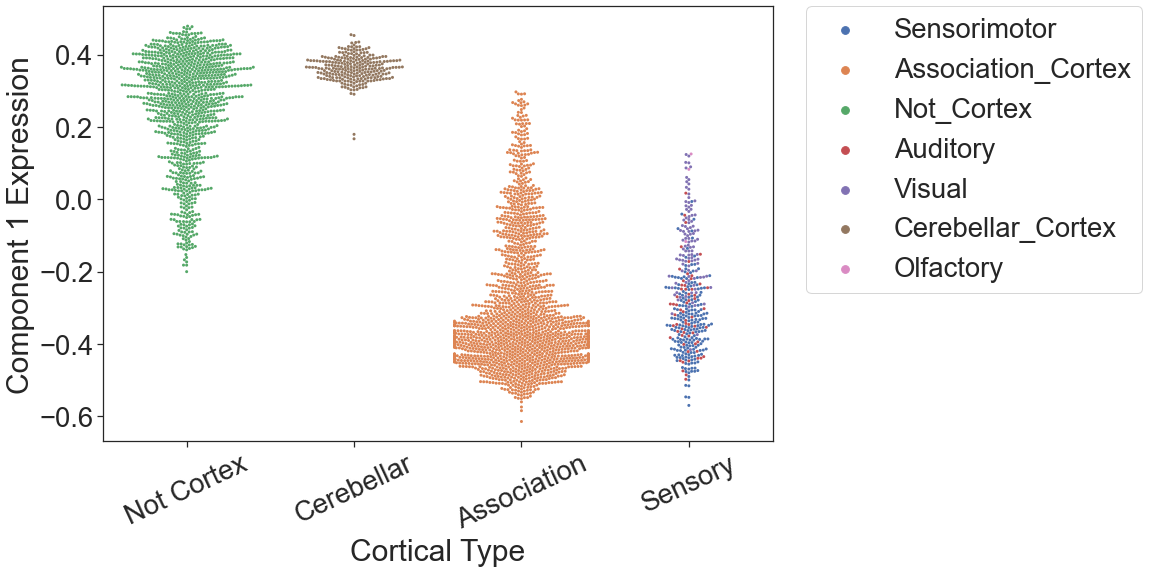

In [153]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Cerebellar_Cortex','Association_Cortex','Sensory']
g=sns.swarmplot(x='Cortical_Type', y='C1_Expression', data=gdf, size=3,
                hue='Sensory_Type', order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Not Cortex','Cerebellar','Association','Sensory'],
                  rotation=25)
plt.xlabel('Cortical Type')
plt.ylabel('Component 1 Expression')
plt.savefig(os.path.join(fig_dir,'C1_Modals.png'),bbox_inches='tight')

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


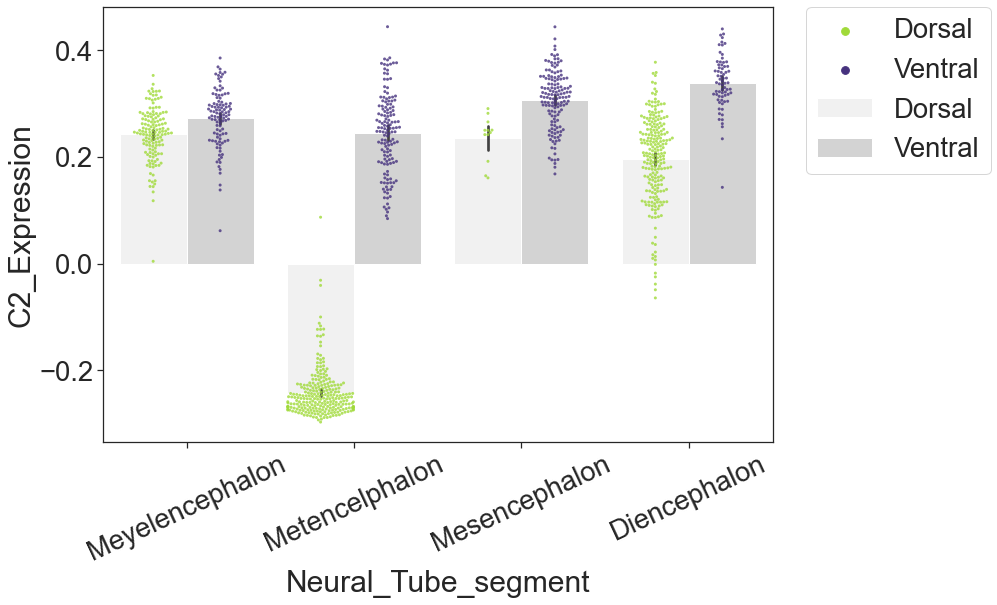

In [158]:
rbpal = [sns.color_palette('viridis')[-1],
                      sns.color_palette('viridis')[0]]
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Meyelencephalon', 'Metencelphalon', 'Mesencephalon', 
         'Diencephalon']
horder = ['Dorsal','Ventral']
sns.barplot(x='Neural_Tube_segment', y='C2_Expression', 
            data=gdf[gdf.Neural_Tube_segment!='Telencephalon'],
            color='lightgray',hue='Neural_Plate',
           order = order,hue_order=horder)
g=sns.swarmplot(x='Neural_Tube_segment', y='C2_Expression', 
              data=gdf[gdf.Neural_Tube_segment!='Telencephalon'],
                hue='Neural_Plate',dodge=True,size=3,alpha=0.8,
              order = order, palette=rbpal,hue_order=horder,
               )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(order,rotation=25)
plt.savefig(os.path.join(fig_dir,'C2_NT-NoTele.png'),bbox_inches='tight')

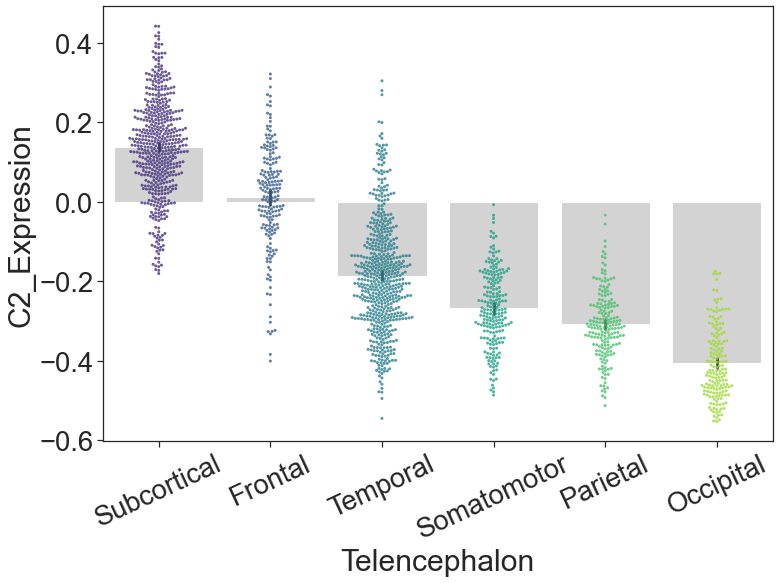

In [165]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Subcortical', 'Frontal', 'Temporal','Somatomotor', 
         'Parietal','Occipital']
sns.barplot(x='Neural_Plate', y='C2_Expression', 
            data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
            color='lightgray',
           order = order,
            hue_order=order
           )
g=sns.swarmplot(x='Neural_Plate', y='C2_Expression', 
              data=gdf[gdf.Neural_Tube_segment=='Telencephalon'],
              order = order, size=3,
                palette='viridis',alpha=0.8)
g.set_xticklabels(order,rotation=25)
plt.xlabel('Telencephalon')
plt.savefig(os.path.join(fig_dir,'C2_NT-TeleOnly.png'),bbox_inches='tight')

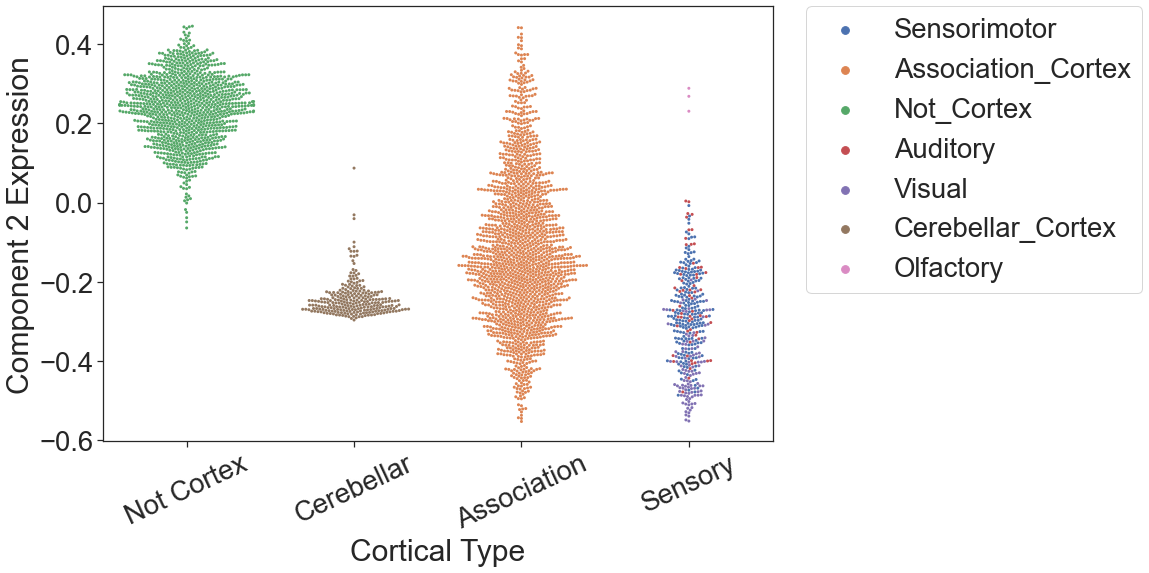

In [169]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Cerebellar_Cortex','Association_Cortex','Sensory']
g=sns.swarmplot(x='Cortical_Type', y='C2_Expression', data=gdf, size=3,
                hue='Sensory_Type', order=order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Not Cortex','Cerebellar','Association','Sensory'],
                  rotation=25)
plt.xlabel('Cortical Type')
plt.ylabel('Component 2 Expression')
plt.savefig(os.path.join(fig_dir,'C2_Modals.pdf'),bbox_inches='tight')

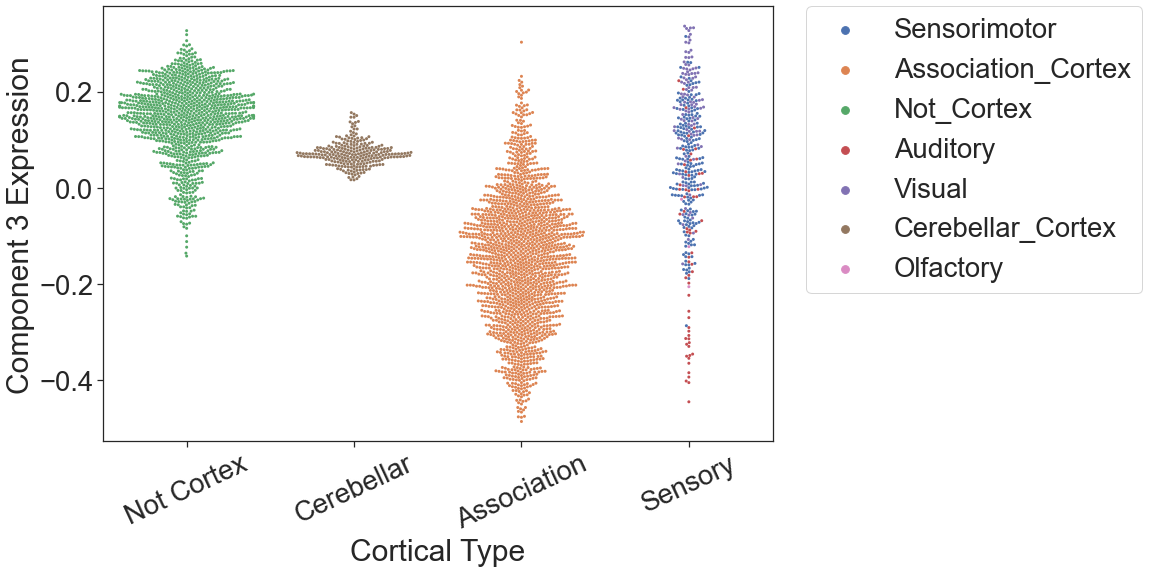

In [171]:
sns.set_context('notebook',font_scale=2.5)
plt.subplots(figsize=(12,8))
order = ['Not Cortex','Cerebellar_Cortex','Association_Cortex','Sensory']
g = sns.swarmplot(x='Cortical_Type', y='C3_Expression',size=3, 
              data=gdf, hue='Sensory_Type',order=order,
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['Not Cortex','Cerebellar','Association','Sensory'],
                  rotation=25)
plt.xlabel('Cortical Type')
plt.ylabel('Component 3 Expression')
plt.savefig(os.path.join(fig_dir,'C3_Modals.pdf'), bbox_inches='tight')

# For PNC analysis

In [172]:
cexp = pandas.DataFrame(index=gdf[gdf.columns[0]])
for i in range(3):
    cexp.loc[:,'C%s'%(i+1)] = np.dot(pca_tfm.values,
                                     pls_mod.x_weights_[:,i])

In [26]:
cexp.to_csv('/Users/jacobv/Science/PLS_GXP/PNC/Genomic_Component_Expression.csv')

# Monkey Evolution

In [34]:
refseq = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/refseq_conversion.csv')
refseq = refseq[refseq.columns[:2]]
refseq.columns = ['rsid','gs']
pc2 = pandas.ExcelFile('/Users/jacobv/Science/PLS_GXP/media-8.xlsx')
pc2 = pc2.parse(pc2.sheet_names[0])
ncols = [] 
for i in range(len(pc2.columns)):
    cnm = pc2.loc[0,pc2.columns[i]]
    if i % 2 == 0:
        rnm = pc2.columns[i]
    else:
        rnm = pc2.columns[(i-1)]
    ncol = '%s_%s'%(rnm,cnm)
    ncols.append(ncol)
pc2.columns = ncols
pc2.drop(0,inplace=True)
pc2.head()

,PFC_Gene,PFC_PC2,HIP_Gene,HIP_PC2,CBL_Gene,CBL_PC2,V1_Gene,V1_PC2
1,NM_021025.3,0.138159,NM_021025.3,0.113917,XM_011534465.2,0.0979418,XR_001740009.1,0.128762
2,XR_001740009.1,0.136566,NM_001206480.2,0.102662,NM_001330533.1,0.095216,XM_011511497.2,0.09436
3,NM_001206480.2,0.125975,XM_011514541.1,0.0837236,NM_001206480.2,0.0935047,NM_002084.4,0.0937957
4,NM_002084.4,0.102506,XR_001740009.1,0.0818965,NM_006040.2,0.0930058,NM_001206480.2,0.091102
5,XM_011539454.2,0.0947831,XM_011510158.2,0.081318,NM_002899.3,0.0905976,XM_011539454.2,0.0856996


In [35]:
refseq.index = refseq.rsid.values
for i, row in pc2.iterrows():
    for reg in ['PFC','HIP','CBL','V1']:
        rsid = row['%s_Gene'%reg]
        xp = row['%s_PC2'%reg]
        refseq.loc[rsid,'%s_PC2'%reg] = xp

In [45]:
allcs = pandas.DataFrame(newc1,copy=True)
allcs.columns = ['C1','gene_symbol','gene_name']
allcs.loc[:,'C2'] = newc2[newc2.columns[0]].values
allcs.loc[:,'C3'] = newc3[newc3.columns[0]].values

In [91]:

for col in [x for x in refseq.columns if 'PC2' in x]:
    print('======%s======'%col)
    anlr = pandas.DataFrame(refseq[['gs',col]].dropna(),copy=True)
    anlr.index = anlr.gs.values[:]
    shared = list(set(anlr.index) & set(allcs.index))
    # address duplicates
    catch = []
    dups = []
    for i in anlr.index:
        if i not in catch:
            catch.append(i)
        else:
            print(i)
            dups.append(i)
    nvals = {}
    for dup in dups:
        nvals.update({dup:anlr.loc[dup,col].mean()})
    anlr.drop(dups,inplace=True)
    for dup,nval in nvals.items():
        anlr.loc[dup,col] = nval
        
    # correlation
    for i in range(1,4):
        r,p = stats.pearsonr(anlr.loc[shared,col],allcs.loc[shared,'C%s'%i])
        print('C%s: r = %s, p = %s'%(i,round(r,3),round(p,3)))


======PFC_PC2======
GTF3C3
MLLT3
RAB3B
TCF20
GABRA4
C1: r = -0.084, p = 0.119
C2: r = -0.028, p = 0.602
C3: r = -0.012, p = 0.824
======HIP_PC2======
GTF3C3
RAB3B
TCF20
GABRA4
C1: r = -0.059, p = 0.315
C2: r = -0.009, p = 0.881
C3: r = -0.049, p = 0.399
======CBL_PC2======
RAB3B
TCF20
C1: r = -0.043, p = 0.491
C2: r = 0.023, p = 0.713
C3: r = -0.078, p = 0.207
======V1_PC2======
GTF3C3
RAB3B
TCF20
GABRA4
C1: r = -0.06, p = 0.305
C2: r = -0.008, p = 0.888
C3: r = 0.033, p = 0.572


#### enrichment

In [96]:
len(allcs) * 0.008

125.06400000000001

In [97]:
(allcs.sort_values('C1').index.values)[:(round(len(allcs)*0.008))]

array(['CTXN3', 'FOXG1', 'TNNT2', 'WNT10A', 'MOXD1', 'ASGR2', 'GGTA1P',
       'OR14I1', 'KLHL29', 'NR2E1', 'ZBBX', 'GDA', 'PART1', 'TESPA1',
       'TEX29', 'ABHD12B', 'HDC', 'FREM3', 'LYPD8', 'GALNTL5', 'LCP2',
       'PRRX1', 'PCDH8', 'OSBPL3', 'LINC02217', 'SLC26A4-AS1', 'EMX2OS',
       'NEK11', 'BAIAP2L2', 'DLX1', 'OLFM4', 'EGR3', 'LINC01158',
       'ARHGAP25', 'GPR20', 'OTX1', 'NRGN', 'ADAMTS19', 'RXFP1', 'SNN',
       'LINC00982', 'ADTRP', 'ASB2', 'KCNV1', 'RTP1', 'NECAB1', 'COL5A2',
       'GDF10', 'OVOL2', 'LY86-AS1', 'PCDH10', 'TEX47', 'RASL10A', 'LHX2',
       'KCNMB4', 'LINC01140', 'FAM213A', 'FAM78A', 'GRID1', 'WFDC1',
       'VILL', 'DPF1', 'EMX2', 'SH2D5', 'KLHL25', 'PLCB1', 'MYO5B',
       'THEMIS', 'PCP4', 'BCL11B', 'EPHB6', 'C9orf24', 'DDAH1', 'CCDC173',
       'COL11A1', 'PRDM16', 'GPATCH4', 'ARX', 'PP12613', 'VWA3A',
       'PCDH20', 'CHRDL1', 'RABEPK', 'HSPH1', 'WIF1', 'CSRNP3', 'SLC26A4',
       'TMEM155', 'HTR1E', 'GAD1', 'FLRT1', 'KIF17', 'STOX1', 'MKL2',
    

In [106]:
ethr = 0.016
n_iter = 1000

dthr = ethr/2
prim_genes = refseq.gs.dropna().values
# enrichment
for i in range(1,4):
    # null
    nullset = []
    for it in range(n_iter):
        null = np.random.choice(allcs.index,round(len(allcs)*dthr))
        nullset.append(len(set(null) & set(prim_genes)))
    nullset = np.array(nullset)
    print('C%s_______'%i)
    nset = (allcs.sort_values('C%s'%i).index.values)[:(round(len(allcs)*dthr))]
    gset = set(prim_genes) & set(nset)
    p = (len(nullset[nullset>len(gset)]) + 1) / n_iter
    print(len(gset),'negatively enriched genes. P =',p,gset)
    pset = (allcs.sort_values('C%s'%i,ascending=False).index.values)[:(round(len(allcs)*dthr))]
    gset = set(prim_genes) & set(pset)
    p = (len(nullset[nullset>len(gset)]) + 1) / n_iter
    print(len(gset),'postively enriched genes. P =',p,gset)

C1_______
10 negatively enriched genes. P = 0.001 {'DDAH1', 'PRDM16', 'COL11A1', 'BCL11B', 'LCP2', 'IER5L', 'PRRX1', 'GDF10', 'WIF1', 'STOX1'}
2 postively enriched genes. P = 0.543 {'PDGFD', 'MAP2K6'}
C2_______
2 negatively enriched genes. P = 0.526 {'SMPX', 'RTKN2'}
6 postively enriched genes. P = 0.018 {'PTPRF', 'DNAAF4', 'PRRX1', 'TPPP3', 'AEBP1', 'GPX3'}
C3_______
5 negatively enriched genes. P = 0.06 {'ATP2B4', 'PCDH19', 'ADGRL3', 'NWD2', 'CEBPA'}
9 postively enriched genes. P = 0.001 {'ONECUT2', 'PCSK1', 'POU3F3', 'NEB', 'PRRX1', 'VWC2', 'CMYA5', 'CLMP', 'SYT2'}


In [108]:
len(prim_genes)

379

In [54]:
newc2.columns

Index([0, 'gene_symbol', 'gene_name'], dtype='object')

In [59]:
newc1.columns = ['C1','gene_symbol','gene_name']
newc1.loc[:,'C2'] = newc2[0].values
newc1.loc[:,'C3'] = newc3[0].values

In [64]:
newc1[newc1.gene_symbol.isin(['CD38','WDR6'])]

,C1,gene_symbol,gene_name,C2,C3
2100,-0.010851,CD38,CD38 molecule,0.018846,0.014293
14731,0.002019,WDR6,WD repeat domain 6,0.018293,-0.008519


In [84]:
newc1.to

,C1,gene_symbol,gene_name,C2,C3
0,0.001822,A1BG,alpha-1-B glycoprotein,0.003711,-0.022104
1,-0.006890,A1BG-AS1,NaN,-0.007837,-0.004443
2,0.004945,A2M,alpha-2-macroglobulin,0.008298,0.002382
3,-0.009122,A2ML1,alpha-2-macroglobulin-like 1,-0.004419,-0.007758
4,-0.001099,A3GALT2,NaN,0.001295,0.001691
...,...,...,...,...,...
15628,0.002159,ZXDC,ZXD family zinc finger C,0.010613,-0.004826
15629,-0.001805,ZYG11B,zyg-11 homolog B (C. elegans),-0.008147,-0.001765
15630,-0.001112,ZYX,zyxin,-0.016958,0.007325
15631,0.010725,ZZEF1,"zinc finger, ZZ-type with EF-hand domain 1",-0.003680,0.006823


# PCs

In [15]:
pca_tfm.shape

(3466, 100)

In [16]:
gdf.shape

(3466, 39)

In [48]:
allpcs = []
for pc in range(pca_tfm.shape[1]):
    gdf.loc[:,'PC'] = pca_tfm.loc[:,pc]
    c_vals = pandas.pivot_table(gdf,values='PC',
                                 index='brain_divison',aggfunc=np.mean
                                )
    c_vals.columns = ['PC%s'%pc]
    allpcs.append(c_vals)
allpcs = pandas.concat(allpcs,axis=1)

In [50]:
allpcs.to_csv('/Users/jacobv/Science/PLS_GXP/Allen_Macrostructure_PCs.csv')

In [56]:
compmat = pandas.DataFrame(pcamod.components_,
                           index = ['C%s'%x for x in range(len(pcamod.components_))],
                           columns = bigdf.columns).T

In [58]:
compmat.to_csv('/Users/jacobv/Science/PLS_GXP/Allen_PC_matrix.csv')